## Predicting Diabetes from Demographics and Body Measures - National Health & Nutrition Examination Survey (NHANES)

### Project Checkpoint 2
#### Group Members: Safa Malik, Ayesha Khan

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.ticker as mtick
from scipy.stats import kruskal

## Data Preprocessing and Data Cleaning

### A. Demographics Data
- Data Download Link: https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Demographics
- Documentation: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DEMO.htm

In [ ]:
# Load Demographics Data 2017-2020 from NHANES
df_dem = pd.read_sas('P_DEMO.xpt', format='xport')

In [ ]:
# Look at the first few records
print(f'shape: {df_dem.shape}')
df_dem.head()

shape: (15560, 29)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,...,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,WTINTPRP,WTMECPRP,SDMVPSU,SDMVSTRA,INDFMPIR
0,109263.0,66.0,2.0,1.0,2.0,NaN,5.0,6.0,2.0,1.0,...,2.0,NaN,NaN,NaN,NaN,7891.762435,8.951816e+03,3.0,156.0,4.66
1,109264.0,66.0,2.0,2.0,13.0,NaN,1.0,1.0,2.0,1.0,...,2.0,1.0,2.0,2.0,1.0,11689.747264,1.227116e+04,1.0,155.0,0.83
2,109265.0,66.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,1.0,...,2.0,NaN,NaN,NaN,NaN,16273.825939,1.665876e+04,1.0,157.0,3.06
3,109266.0,66.0,2.0,2.0,29.0,NaN,5.0,6.0,2.0,2.0,...,2.0,1.0,2.0,2.0,1.0,7825.646112,8.154968e+03,2.0,168.0,5.00
4,109267.0,66.0,1.0,2.0,21.0,NaN,2.0,2.0,NaN,2.0,...,2.0,NaN,NaN,NaN,NaN,26379.991724,5.397605e-79,1.0,156.0,5.00


#### Preparing Column Names
We notice that the column names are 'coded' and not very intuitive. So we leveraged the [data documentation](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DEMO.htm) to:
1. Keep only the required columns
2. Rename the column names so they are more intuitive

In [ ]:
# Only keep required columns
columns_to_keep = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDBORN4', 'DMDMARTZ', 'RIDEXPRG', 'DMDYRUSZ', 'DMDEDUC2', 'INDFMPIR']
df_dem = df_dem[columns_to_keep]

In [ ]:
# Rename the columns so they are more understandable
df_dem.rename(columns={
    'SEQN': 'Sequence_Number',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'RIDRETH3': 'Race',
    'DMDBORN4': 'Country_Birth',
    'DMDMARTZ': 'Marital_Status',
    'RIDEXPRG': 'Pregnancy_Status',
    'DMDYRUSZ': 'Time_In_US',
    'DMDEDUC2': 'Education_Level',
    'INDFMPIR': 'FamilyIncome_to_Poverty'
}, inplace=True)
df_dem.head()

,Sequence_Number,Gender,Age,Race,Country_Birth,Marital_Status,Pregnancy_Status,Time_In_US,Education_Level,FamilyIncome_to_Poverty
0,109263.0,1.0,2.0,6.0,1.0,NaN,NaN,NaN,NaN,4.66
1,109264.0,2.0,13.0,1.0,1.0,NaN,NaN,NaN,NaN,0.83
2,109265.0,1.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,3.06
3,109266.0,2.0,29.0,6.0,2.0,3.0,2.0,2.0,5.0,5.00
4,109267.0,2.0,21.0,2.0,2.0,3.0,3.0,3.0,4.0,5.00


#### Handling categorical fields with codes:

- Gender (RIAGENDR): 1=Male, 2=Female.


- Race (RIDRETH3): 1=Mexican American, 2=Other Hispanic, 3=NH White, 4=NH Black, 6=NH Asian, 7=Other/Multiracial (5 unused).


- Country_Birth (DMDBORN4): 1=Born in US, 2=Born elsewhere.


- Time_In_US (DMDYRUSZ) (asked of foreign-born; US-born are NA): 1=<5y, 2=5–<15y, 3=15–<30y, 4=≥30y.


- Education_Level (DMDEDUC2) (only valid for age ≥20): 1=<9th, 2=9–11th (incl. 12th, no diploma), 3=HS/GED, 4=Some college/AA, 5=College+.


- Marital_Status (DMDMARTZ) (released for age ≥20): 1=Married/Living with partner, 2=Widowed/Divorced/Separated, 3=Never married.


- Pregnancy_Status (RIDEXPRG) (released only for women 20–44): 1=Pregnant, 2=Not pregnant, 3=Could not be determined.

In [ ]:
# Define the mapping from numeric codes to descriptive strings
gender_map = {1: 'Male', 2: 'Female'}
race_map = {1: 'Mexican American', 2: 'Other Hispanic', 3: 'NH White', 4: 'NH Black', 6: 'NH Asian', 7: 'Other/Multiracial'}
country_map = {1: 'US Born', 2: 'Others', 77: 'RefusedResponse', 99: 'Dont Know'}
marital_map = {1: 'Married/LiveIn', 2: 'Wid/Div/Sep', 3: 'Never Married', 77:'RefusedResoponse', 99: 'Dont Know'}
pregnancy_map = {1: 'Yes', 2: 'No', 3: 'Dont Know'}
ustime_map= {1:'<5y', 2:'5–<15y', 3:'15–<30y', 4:'>=30y', 77:'RefusedResoponse', 99: 'Dont Know'}
edu_map = {1: '<9th', 2: '9–11th', 3: 'HS/GED', 4: 'Some college/AA', 5: 'College+', 77:'RefusedResoponse', 99: 'Dont Know'}



# Use .map() to decode the categorical columns - This overwrites the original columns with the new string values
df_dem['Gender'] = df_dem['Gender'].map(gender_map)
df_dem['Race'] = df_dem['Race'].map(race_map)
df_dem['Country_Birth'] = df_dem['Country_Birth'].map(country_map)
df_dem['Marital_Status'] = df_dem['Marital_Status'].map(marital_map)
df_dem['Pregnancy_Status'] = df_dem['Pregnancy_Status'].map(pregnancy_map)
df_dem['Time_In_US'] = df_dem['Time_In_US'].map(ustime_map)
df_dem['Education_Level'] = df_dem['Education_Level'].map(edu_map)

df_dem

,Sequence_Number,Gender,Age,Race,Country_Birth,Marital_Status,Pregnancy_Status,Time_In_US,Education_Level,FamilyIncome_to_Poverty
0,109263.0,Male,2.0,NH Asian,US Born,NaN,NaN,NaN,NaN,4.66
1,109264.0,Female,13.0,Mexican American,US Born,NaN,NaN,NaN,NaN,0.83
2,109265.0,Male,2.0,NH White,US Born,NaN,NaN,NaN,NaN,3.06
3,109266.0,Female,29.0,NH Asian,Others,Never Married,No,5–<15y,College+,5.00
4,109267.0,Female,21.0,Other Hispanic,Others,Never Married,Dont Know,15–<30y,Some college/AA,5.00
...,...,...,...,...,...,...,...,...,...,...
15555,124818.0,Male,40.0,NH Black,US Born,Married/LiveIn,NaN,NaN,College+,3.82
15556,124819.0,Male,2.0,NH Black,US Born,NaN,NaN,NaN,NaN,0.07
15557,124820.0,Female,7.0,NH White,US Born,NaN,NaN,NaN,NaN,1.22
15558,124821.0,Male,63.0,NH Black,US Born,Wid/Div/Sep,NaN,NaN,9–11th,3.71


### B. Diabetes Questionnaire Data

- Data Download Link: https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&Cycle=2017-2020
- Documentation: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DIQ.htm

In [ ]:
# Load Diabetes Data 2017-2020 from NHANES
df_db = pd.read_sas('P_DIQ.xpt', format='xport')

In [ ]:
df_db.head()

,SEQN,DIQ010,DID040,DIQ160,DIQ180,DIQ050,DID060,DIQ060U,DIQ070,DIQ230,...,DIQ300D,DID310S,DID310D,DID320,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080
0,109263.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109264.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,109265.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,109266.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,109267.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Preparing Column Names
We notice that the column names are 'coded' and not very intuitive. So we leveraged the [data documentation](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DEMO.htm) to:
1. Keep only the required columns
2. Rename the column names so they are more intuitive

In [ ]:
# Only keep required columns
columns_to_keep = ['SEQN', 'DIQ010', 'DIQ160']
df_db = df_db[columns_to_keep]

In [ ]:
# Rename the columns so they are more understandable
df_db.rename(columns={
    'SEQN': 'Sequence_Number',
    'DIQ010': 'Dr_Diagnosed_Diab',
    'DIQ160': 'Ever_PreDiab'
}, inplace=True)
df_db.head()

,Sequence_Number,Dr_Diagnosed_Diab,Ever_PreDiab
0,109263.0,2.0,NaN
1,109264.0,2.0,2.0
2,109265.0,2.0,NaN
3,109266.0,2.0,1.0
4,109267.0,2.0,2.0


#### Handling categorical fields with codes:

- Dr_Diagnosed_Diab (DIQ010): 1=Yes, 2=No, 3=Borderline, 7= Refused, 8 = Don't Know


- Ever_PreDiab: 1=Yes, 2=No, 7= Refused, 9 = Don't Know

In [ ]:
# Define the mapping from numeric codes to descriptive strings
diag_map = {1: 'Yes', 2: 'No', 3: 'Borderline', 7:'Refused', 8: 'Dont Know'}
everdiab_map = {1: 'Yes', 2: 'No', 7:'Refused', 9: 'Dont Know'}


# Use .map() to decode the categorical columns - This overwrites the original columns with the new string values
df_db['Dr_Diagnosed_Diab'] = df_db['Dr_Diagnosed_Diab'].map(diag_map)
df_db['Ever_PreDiab'] = df_db['Ever_PreDiab'].map(everdiab_map)


df_db

,Sequence_Number,Dr_Diagnosed_Diab,Ever_PreDiab
0,109263.0,No,NaN
1,109264.0,No,No
2,109265.0,No,NaN
3,109266.0,No,Yes
4,109267.0,No,No
...,...,...,...
14981,124818.0,No,No
14982,124819.0,No,NaN
14983,124820.0,No,NaN
14984,124821.0,Borderline,NaN


### C. Body Examination (BMI) Data

- Data Download Link: https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Examination&Cycle=2017-2020
- Documentation: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_BMX.htm

In [ ]:
# Load BMI Data 2017-2020 from NHANES
df_bmi = pd.read_sas('P_BMX.xpt', format='xport')

In [ ]:
df_bmi.head()

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,BMXLEG,BMILEG,BMXARML,BMIARML,BMXARMC,BMIARMC,BMXWAIST,BMIWAIST,BMXHIP,BMIHIP
0,109263.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109264.0,1.0,42.2,NaN,NaN,NaN,NaN,NaN,154.7,NaN,...,36.3,NaN,33.8,NaN,22.7,NaN,63.8,NaN,85.0,NaN
2,109265.0,1.0,12.0,NaN,91.6,NaN,NaN,NaN,89.3,NaN,...,NaN,NaN,18.6,NaN,14.8,NaN,41.2,NaN,NaN,NaN
3,109266.0,1.0,97.1,NaN,NaN,NaN,NaN,NaN,160.2,NaN,...,40.8,NaN,34.7,NaN,35.8,NaN,117.9,NaN,126.1,NaN
4,109269.0,3.0,13.6,NaN,90.9,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN


#### Preparing Column Names
We notice that the column names are 'coded' and not very intuitive. So we leveraged the [data documentation](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_BMX.htm) to:
1. Keep only the required columns
2. Rename the column names so they are more intuitive

In [ ]:
# Only keep required columns
columns_to_keep = ['SEQN', 'BMXBMI', 'BMXWAIST']
df_bmi = df_bmi[columns_to_keep]

In [ ]:
# Rename the columns so they are more understandable
df_bmi.rename(columns={
    'SEQN': 'Sequence_Number',
    'BMXBMI': 'BMI',
    'BMXWAIST': 'Waist_Circumference'
}, inplace=True)
df_bmi.head()

,Sequence_Number,BMI,Waist_Circumference
0,109263.0,NaN,NaN
1,109264.0,17.6,63.8
2,109265.0,15.0,41.2
3,109266.0,37.8,117.9
4,109269.0,NaN,NaN


## Joining the Data
#### Using inner join to get all participants that have diabetes data as well as demographics data

In [ ]:
# Checking data type for the sequence columns in both tables before joining
#print(df_dem['Sequence_Number'].dtype)df_db
#print(df_db['Sequence_Number'].dtype)

# Converting to string
df_dem['Sequence_Number'] = df_dem['Sequence_Number'].astype(str)
df_db['Sequence_Number'] = df_db['Sequence_Number'].astype(str)
df_bmi['Sequence_Number'] = df_bmi['Sequence_Number'].astype(str)

In [ ]:
df_combined = pd.merge(df_dem, df_db, on='Sequence_Number', how='inner')
df_combined = pd.merge(df_combined, df_bmi, on='Sequence_Number', how='inner')

In [ ]:
print(f"""Total Records in:
- Demographics Data: {len(df_dem)}
- Diabetes Data: {len(df_db)}
- BMI Data: {len(df_bmi)}
- Combined Data after joining: {len(df_combined)}
""")

Total Records in:
- Demographics Data: 15560
- Diabetes Data: 14986
- BMI Data: 14300
- Combined Data after joining: 13772



--------------

## Missing Values

/tmp/ipython-input-308237008.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=miss.values, y=miss.index, palette="viridis")


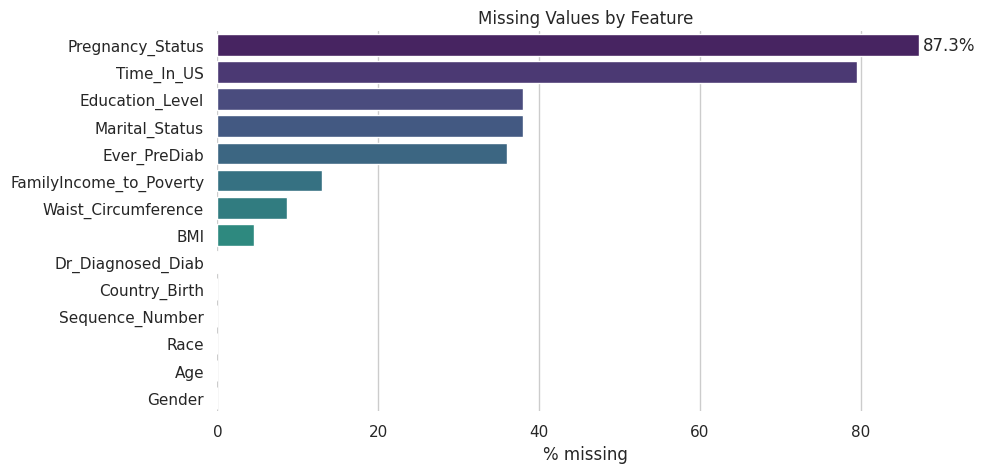

In [ ]:
# Plot missing values by column
miss = (df_combined.isna().mean()*100).sort_values(ascending=False)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, max(4, 0.35*len(miss))))
ax = sns.barplot(x=miss.values, y=miss.index, palette="viridis")
ax.set(xlabel="% missing", ylabel="", title="Missing Values by Feature")
ax.bar_label(ax.containers[0], fmt="%.1f%%", padding=3)
sns.despine(left=True, bottom=True)
plt.tight_layout(); plt.show()

- Very high “missing” for Pregnancy_Status (87%) and Time_In_US (79.5%) are mostly not-applicable:
  - Pregnancy is only asked of females of reproductive age;
  - Time in U.S. is skipped for U.S.-born respondents. We plan to recode these to “Not in universe” instead of treating as true missing.


- Education_Level, Marital_Status, Ever_PreDiab (~36–38% “missing”) are largely skip patterns too (e.g., items not asked of children/teens, or “Refused/Don’t know”).
  - We will analyze these only among age-eligible adults and keep a separate “NIU/skip” category.


- Waist_Circumference (8.7%) and BMI (4.6%) may be due to missed exams or exclusions. We will handle these teo based on the documentation.


- Core demographics (Sequence_Number, Gender, Age, Race, Country_Birth, Dr_Diagnosed_Diab) are essentially complete.

#### Handling missing values

Methodology on Handling Missing Values:

- We will analyze each variable only for people it actually applies to: Mark NIU/skip (not asked) separately from the real missing values.
- We won't do listwise deletion as it will remove lots of kids and US-born adults for no reason.

In [ ]:
df = df_combined
NIU = "NIU (not asked)"

# 1. Define "universes" - relevant population only
is_adult20       = df["Age"] >= 20
is_female_12_59  = (df["Gender"] == "Female") & df["Age"].between(12, 59)
is_foreign_born  = df["Country_Birth"].ne("US Born")


# 2. Assign NIU (structural missing) where questions weren't asked
# Pregnancy: only females 12–59
df.loc[~is_female_12_59 & df["Pregnancy_Status"].isna(), "Pregnancy_Status"] = NIU

# Time in U.S.: only for foreign-born
df.loc[~is_foreign_born & df["Time_In_US"].isna(), "Time_In_US"] = NIU

# Education & Marital status: analyze for adults (NHANES commonly uses 20+)
for col in ["Education_Level", "Marital_Status"]:
    df.loc[~is_adult20 & df[col].isna(), col] = NIU

# Ever told prediabetes: adult item (treat <20 as NIU)
df.loc[~is_adult20 & df["Ever_PreDiab"].isna(), "Ever_PreDiab"] = NIU



# 3. Make string columns categorical
cat_cols = ["Gender","Race","Country_Birth","Marital_Status","Pregnancy_Status",
            "Time_In_US","Education_Level","Dr_Diagnosed_Diab","Ever_PreDiab"]
for c in cat_cols:
    if c in df:
        df[c] = df[c].astype("category")

# Creating subsets to use for future analysis:
adults      = df[is_adult20]            # for education, marital status, prediabetes
preg_univ   = df[is_female_12_59]       # for pregnancy analyses
immigrants  = df[is_foreign_born]       # for time-in-US analyses
df

,Sequence_Number,Gender,Age,Race,Country_Birth,Marital_Status,Pregnancy_Status,Time_In_US,Education_Level,FamilyIncome_to_Poverty,Dr_Diagnosed_Diab,Ever_PreDiab,BMI,Waist_Circumference
0,109263.0,Male,2.0,NH Asian,US Born,NIU (not asked),NIU (not asked),NIU (not asked),NIU (not asked),4.66,No,NIU (not asked),NaN,NaN
1,109264.0,Female,13.0,Mexican American,US Born,NIU (not asked),NaN,NIU (not asked),NIU (not asked),0.83,No,No,17.6,63.8
2,109265.0,Male,2.0,NH White,US Born,NIU (not asked),NIU (not asked),NIU (not asked),NIU (not asked),3.06,No,NIU (not asked),15.0,41.2
3,109266.0,Female,29.0,NH Asian,Others,Never Married,No,5–<15y,College+,5.00,No,Yes,37.8,117.9
4,109269.0,Male,2.0,Other Hispanic,US Born,NIU (not asked),NIU (not asked),NIU (not asked),NIU (not asked),0.96,No,NIU (not asked),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13767,124818.0,Male,40.0,NH Black,US Born,Married/LiveIn,NIU (not asked),NIU (not asked),College+,3.82,No,No,38.2,114.7
13768,124819.0,Male,2.0,NH Black,US Born,NIU (not asked),NIU (not asked),NIU (not asked),NIU (not asked),0.07,No,NIU (not asked),17.5,48.4
13769,124820.0,Female,7.0,NH White,US Born,NIU (not asked),NIU (not asked),NIU (not asked),NIU (not asked),1.22,No,NIU (not asked),15.1,57.5
13770,124821.0,Male,63.0,NH Black,US Born,Wid/Div/Sep,NIU (not asked),NIU (not asked),9–11th,3.71,Borderline,NaN,25.5,97.1


## Check for Duplicates in the Primary Key Column

In [ ]:
duplicate_count = df['Sequence_Number'].duplicated().sum()
print(f"Total duplicate count in 'Sequence_Number': {duplicate_count}")

Total duplicate count in 'Sequence_Number': 0


No duplicates found in our primary key column, we can proceed with EDA

-------------

-------------

## Exploratory Data Analysis

### Statistical Summary of the dataset


In [ ]:
print(df.columns)
print(df.info())
print(df.describe())

Index(['Sequence_Number', 'Gender', 'Age', 'Race', 'Country_Birth',
       'Marital_Status', 'Pregnancy_Status', 'Time_In_US', 'Education_Level',
       'FamilyIncome_to_Poverty', 'Dr_Diagnosed_Diab', 'Ever_PreDiab', 'BMI',
       'Waist_Circumference'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Sequence_Number          13772 non-null  object  
 1   Gender                   13772 non-null  category
 2   Age                      13772 non-null  float64 
 3   Race                     13772 non-null  category
 4   Country_Birth            13772 non-null  category
 5   Marital_Status           13772 non-null  category
 6   Pregnancy_Status         11745 non-null  category
 7   Time_In_US               13767 non-null  category
 8   Education_Level          13759 non-null  category
 9   Fami

**Interpretation of the statistical summaries:**

The total number of paticipants were 13,772 but there were a significant number of missing values across records. The most number of missing values were seen in the Pregancy_Status and Income columns. Most of the data is categorical, with only 4 out of 14 columns.
For the numerical columns (Age, Family Income to Poverty Ratio, BMI, and Waist Circumference, we can observe the distribution shape of each of the variables).

### Distribution of Features

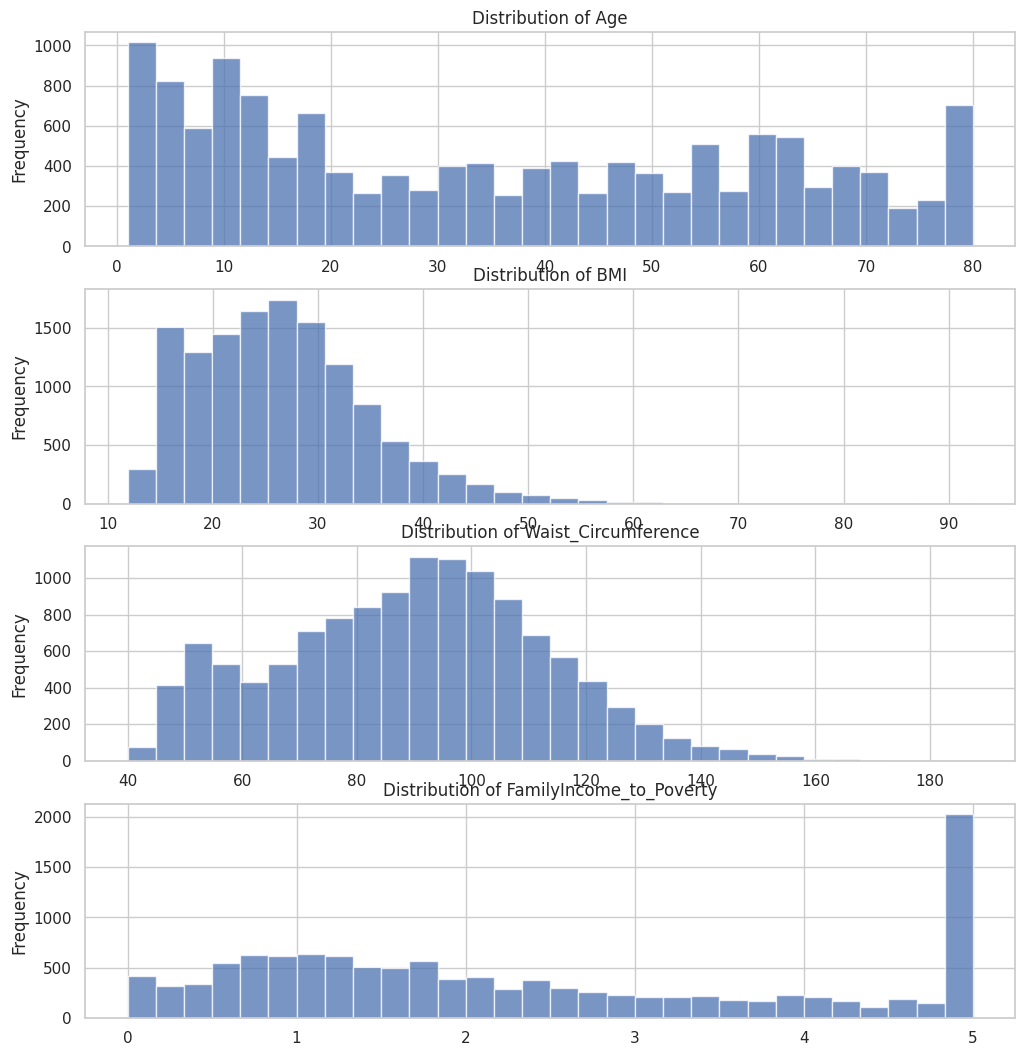

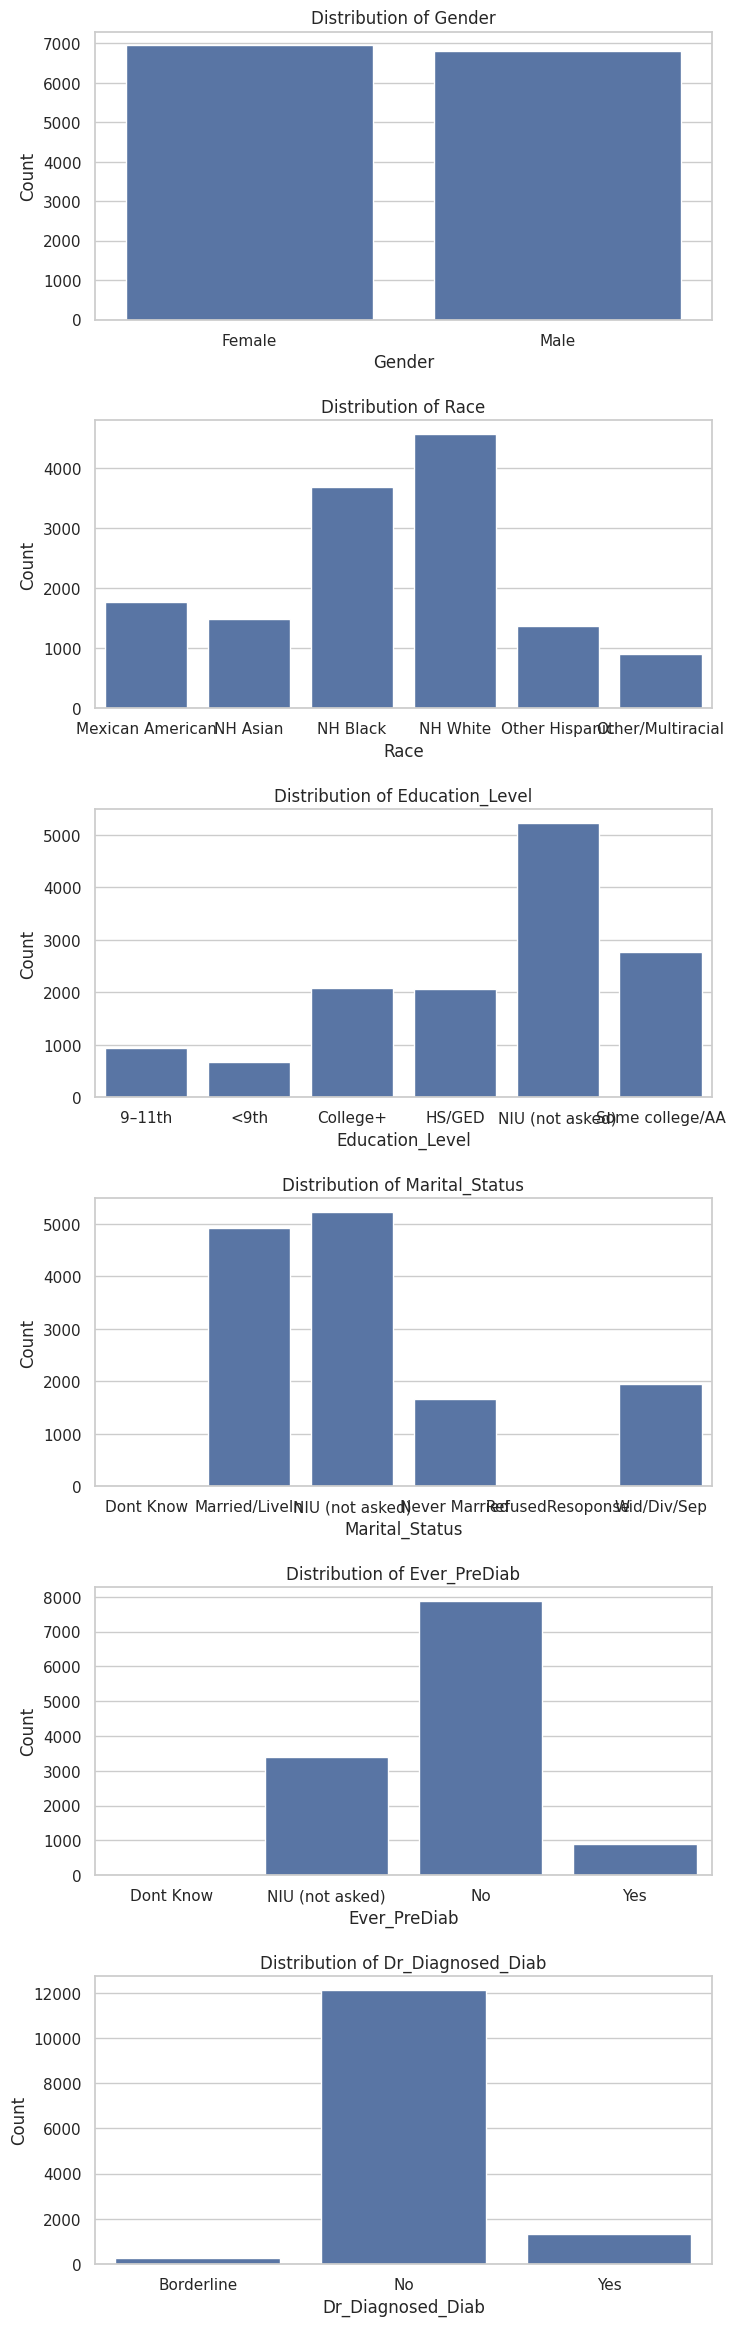

In [ ]:
# 1) Selecting relevant numeric and categorical features
num_features = ["Age", "BMI", "Waist_Circumference", "FamilyIncome_to_Poverty"]
cat_features = ["Gender", "Race", "Education_Level", "Marital_Status", "Ever_PreDiab", "Dr_Diagnosed_Diab"]

# 2) Ensure numeric columns are numeric (coerce invalid to NaN so hist works)
for col in num_features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3) Plot Hisotgrams for numeric features
n_num = len(num_features)
plt.figure(figsize=(12, 3.2 * n_num))
for i, col in enumerate(num_features, 1):
    ax = plt.subplot(n_num, 1, i)
    df[col].dropna().plot(kind="hist", bins=30, alpha=0.75, edgecolor="white", ax=ax)
    ax.set_title(f"Distribution of {col}")


# 4) Create subplots for each categorical feature
fig, axes = plt.subplots(nrows=len(cat_features), ncols=1, figsize=(8, 4 * len(cat_features)))
fig.tight_layout(pad=4.0) # Adjust padding between subplots

for i, col in enumerate(cat_features):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.show()

**Interpretation of Distributions:**

**Numeric Features:**
- Age looks somewhat bimodal as we can notice many young children and many older adults.
- BMI is right-skewed (peak in the 20–30 range with a long tail to high values).
- Waist circumference is roughly bell-shaped with a right tail.
- FamilyIncome_to_Poverty (PIR) is right-skewed with a clear top-code spike at 5 (treat as “5+” rather than an exact value).

**Categorical:**
- Gender is ~balanced. Race is dominated by NH White and NH Black with smaller other groups.
- Education and Marital_Status contain many “NIU (not asked)” entries—consistent with the large number of children.
- Dr_Diagnosed_Diab and Ever_PreDiab are highly imbalanced with “No” as the majority class.

----

### Variance, covariance, and correlation of the dataset

In [ ]:
# find correlation and covariance between numeric variables

df_numeric = df.select_dtypes(include=[float, int])
print(df_numeric.var(), '\n') # calculate variance of numeric columns
print(df_numeric.corr(), '\n')  # calculate correlation matrix with Pearson coefficient
print(df_numeric.cov(), '\n')   # calculate covariance matrix

Age                        611.758862
FamilyIncome_to_Poverty      2.646127
BMI                         70.893746
Waist_Circumference        535.932049
dtype: float64 

                              Age  FamilyIncome_to_Poverty       BMI  \
Age                      1.000000                 0.147039  0.463421   
FamilyIncome_to_Poverty  0.147039                 1.000000  0.025979   
BMI                      0.463421                 0.025979  1.000000   
Waist_Circumference      0.625398                 0.070638  0.933210   

                         Waist_Circumference  
Age                                 0.625398  
FamilyIncome_to_Poverty             0.070638  
BMI                                 0.933210  
Waist_Circumference                 1.000000   

                                Age  FamilyIncome_to_Poverty         BMI  \
Age                      611.758862                 5.911438   94.720874   
FamilyIncome_to_Poverty    5.911438                 2.646127    0.357546   
BMI  

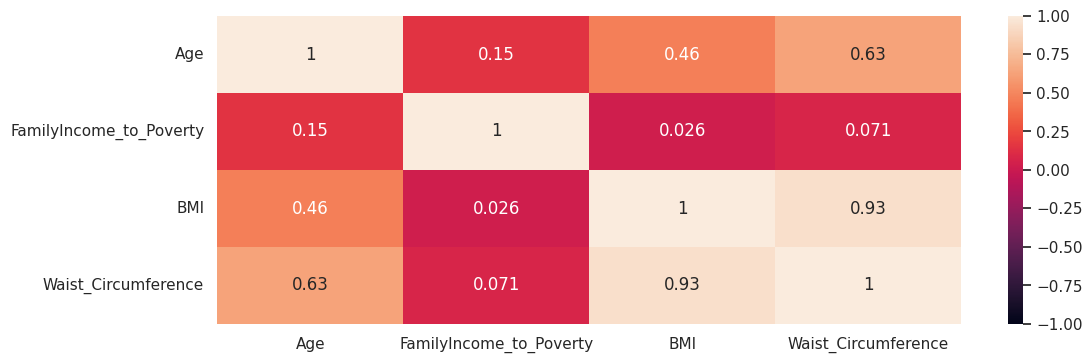

In [ ]:
plt.figure(figsize=(12, 4))
sns.heatmap(df_numeric.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

**Interpretation:**
Based on Pearson correlation, we observe very weak correlation between Age and Waist Circumference/BMI. There was also a weak correlation between Age and Family Income to Poverty ratio, but still older people tend to have slightly higher family income to poverty ratios.

In [ ]:
print(df[df['Age'] >= 80]['Age'].count())
df['Age'].value_counts()

576


,count
Age,
80.0,576
2.0,388
1.0,357
10.0,320
11.0,311
...,...
75.0,88
77.0,72
76.0,71


**Trend of age among participants**

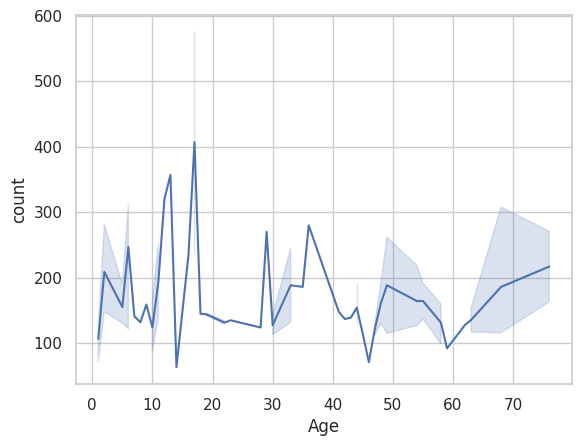

In [ ]:
sns.lineplot(data=df, x=df['Age'], y=df['Age'].value_counts())
plt.show()

We would expect the graph to decrease after age 70 due to old age deaths. However, the graph line rises indicating more participants of age 80 than 70, for example. This is due to the nature of the survey, where all ages above 80 years were recorded as 80 due to disclosure concerns (MNAR).

**Exploring Variation in Income to Poverty Ratio across Age Groups**

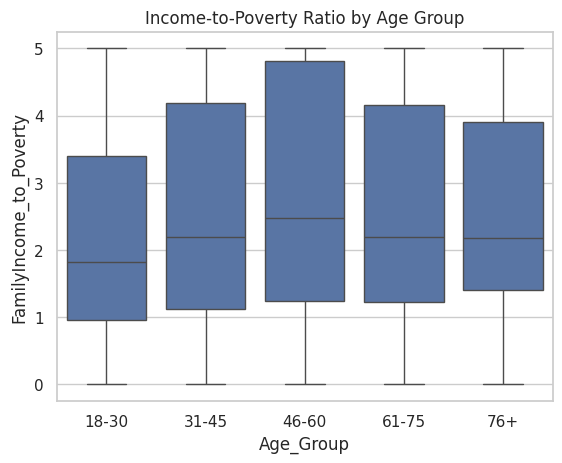

In [ ]:
df['Age_Group'] = pd.cut(df['Age'],
                            bins=[18, 30, 45, 60, 75, 100],
                            labels=['18-30', '31-45', '46-60', '61-75', '76+'])

sns.boxplot(data=df, x='Age_Group', y='FamilyIncome_to_Poverty', showfliers=True)
# sns.stripplot(data=df, x='Age_Group', y='FamilyIncome_to_Poverty', color='black', alpha=0.4)

plt.title('Income-to-Poverty Ratio by Age Group')
plt.show()


There wasn't a strong correlation observed between between family income to poverty ratio and age. However, as expected, with increase in age, the average family income to poverty ratio increases from young adulthood to middle age indicating job stability, and decreases after 60 years of age indicating finances decline post-retirement.

**Exploring Variation in BMI with Increase in Age**

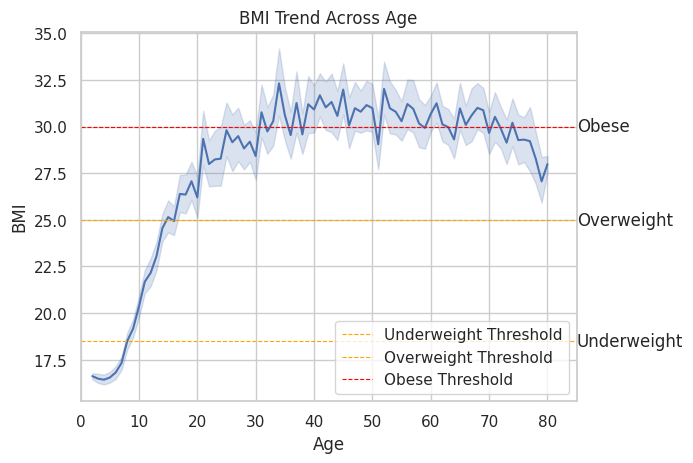

In [ ]:
sns.lineplot(data=df, x=df['Age'], y=df['BMI'])
# BMI guideline lines
plt.axhline(18.5, linestyle='--', linewidth=0.8, color="orange", label='Underweight Threshold')
plt.axhline(25, linestyle='--', linewidth=0.8, color="orange", label='Overweight Threshold')
plt.axhline(30, linestyle='--', linewidth=0.8, color="red", label='Obese Threshold')

plt.text(85, 18.5, 'Underweight', va='center')
plt.text(85, 25, 'Overweight', va='center')
plt.text(85, 30, 'Obese', va='center')

plt.xlim(0, 85)
plt.title('BMI Trend Across Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend()
# plt.show()
plt.show()

It can be observed that average BMI rose with age. On average, participants around 8 years completely passed the underweight BMI category, and maintained a normal BMI for the next few years. Surprisingly, the average BMI of the participants rose above the overweight category at age 14, passed the obese category at age 30, and remained alost completely in the obese category till age 70. Afterwards, the BMI dropped slightly and into the overweight category for ages above 70. (categories defined by the NIH: https://www.nhlbi.nih.gov/sites/default/files/media/docs/bmi_tbl.pdf)

-----

**Exploring Relationship between Family Income to Poverty Ratio and Diabetes Diagnosis**

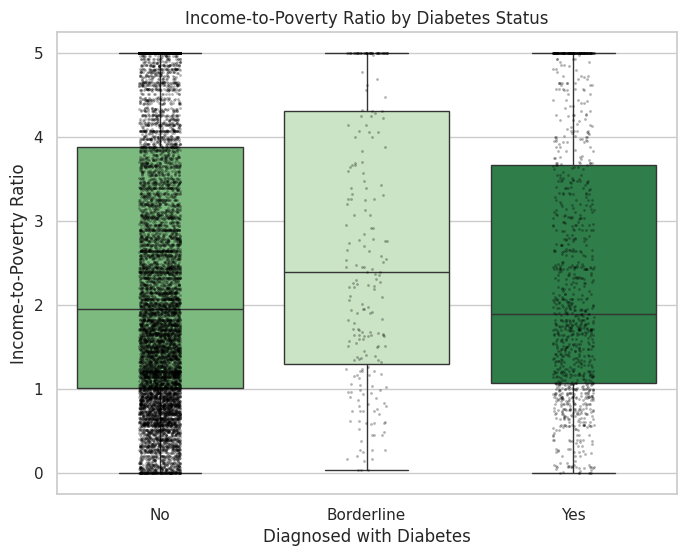

In [ ]:
plt.figure(figsize=(8,6))
cat_order = ['No', 'Borderline', 'Yes']
sns.boxplot(
    data=df,
    x='Dr_Diagnosed_Diab',
    y='FamilyIncome_to_Poverty',
    order=cat_order,
    hue='Dr_Diagnosed_Diab',
    palette='Greens',
    legend=False,
    showfliers=False
)
sns.stripplot(
    data=df, x='Dr_Diagnosed_Diab', y='FamilyIncome_to_Poverty',
    color='black', size=2, alpha=0.3
)
plt.title('Income-to-Poverty Ratio by Diabetes Status')
plt.xlabel('Diagnosed with Diabetes')
plt.ylabel('Income-to-Poverty Ratio')
plt.show()

**Interpretation:**
Median income-to-poverty ratios are slightly lower among participants with diabetes, indicating limited socioeconomic differences but suggesting potential barriers to helathcare and lifestyle resources.

**Exploring the ratio of diabetes across genders**

In [ ]:
gender_diab_counts = df.value_counts(subset=['Gender', 'Dr_Diagnosed_Diab']).reset_index()
print(gender_diab_counts)

   Gender Dr_Diagnosed_Diab  count
0  Female                No   6199
1    Male                No   5949
2    Male               Yes    724
3  Female               Yes    624
4    Male        Borderline    142
5  Female        Borderline    126


<Figure size 800x600 with 0 Axes>

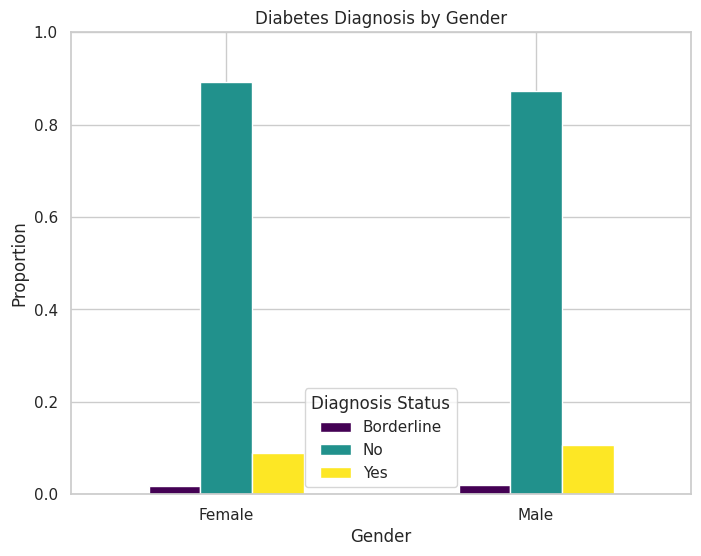

In [ ]:
gender_normalized = pd.crosstab(
    df['Gender'],
    df['Dr_Diagnosed_Diab'],
    normalize='index'
)

plt.figure(figsize=(8,6))
ax = gender_normalized.plot(kind='bar', figsize=(8,6), colormap='viridis')

plt.title('Diabetes Diagnosis by Gender')
plt.ylabel('Proportion')
plt.xlabel('Gender')

plt.legend(
    title='Diagnosis Status',
    labels=gender_normalized.columns
)

plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


A large proprtion of participants were not diagnosed as diabetic amongst both male and female participants. In order to compare the proportion of borderline and diabetic participants, we can zoom in by considering only these two categories in oir next plot.

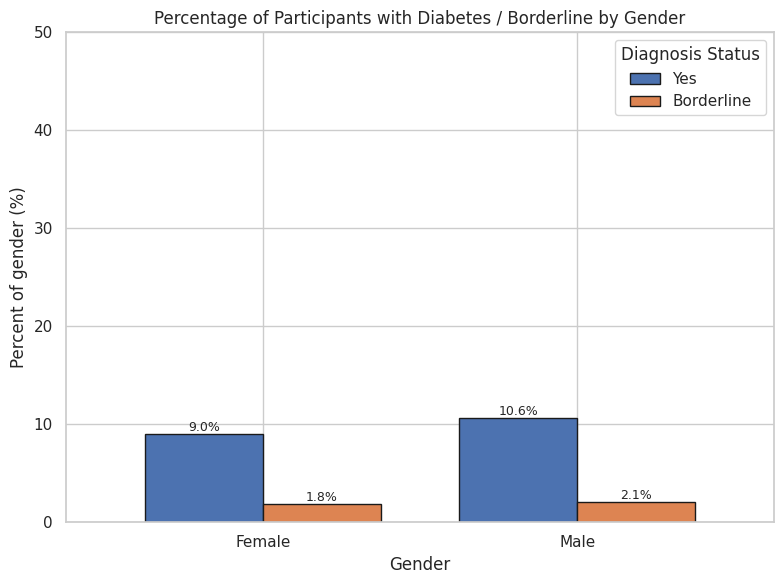

In [ ]:

gender_diab = pd.crosstab(
    df['Gender'],
    df['Dr_Diagnosed_Diab'],
)

# exclude for any rows where gender is missing, and select only 'Yes' and 'Borderline' columns
cols = [c for c in ['Yes', 'Borderline'] if c in gender_diab.columns]
filtered = gender_diab[cols]

# total participants per gender for normalization
gender_totals = pd.crosstab(df['Gender'], df['Dr_Diagnosed_Diab']).sum(axis=1)
gender_percent = filtered.div(gender_totals, axis=0) * 100

# Plot
ax = gender_percent.plot(kind='bar', figsize=(8,6), width=0.75, edgecolor='k')

plt.title('Percentage of Participants with Diabetes / Borderline by Gender')
plt.ylabel('Percent of gender (%)')
plt.xlabel('Gender')
plt.ylim(0, 50)
plt.xticks(rotation=0)
plt.legend(title='Diagnosis Status')
# Annotate bars with percent values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


A slightly higher proportion of male participants were borderline diabetic and diagnosed diabetic than female participants.

## 1. Kruskal–Wallis test (non-parametric one-way ANOVA) for Age and Diabetes

Because we’re comparing a continuous variable (Age) across three independent diabetes groups and the data are likely non-normal, the Kruskal–Wallis test gives a non-parametric omnibus test of median differences without assuming normality.

In [ ]:
# Kruskal–Wallis test (non-parametric one-way ANOVA) for Age and Diabetes:

#1. Separate age data by diabetes status
age_no_diabetes = df[df['Dr_Diagnosed_Diab'] == 'No']['Age']
age_yes_diabetes = df[df['Dr_Diagnosed_Diab'] == 'Yes']['Age']
age_borderline_diabetes = df[df['Dr_Diagnosed_Diab'] == 'Borderline']['Age']

#2. Perform the Kruskal-Wallis H test
statistic, p_value = kruskal(age_no_diabetes, age_yes_diabetes, age_borderline_diabetes)

print(f"Kruskal-Wallis H-statistic: {statistic:.2f}")
print(f"P-value: {p_value:.4f}")

#3. Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in median age among the diabetes status groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in median age among the diabetes status groups.")

Kruskal-Wallis H-statistic: 1832.00
P-value: 0.0000
Reject the null hypothesis: There is a significant difference in median age among the diabetes status groups.


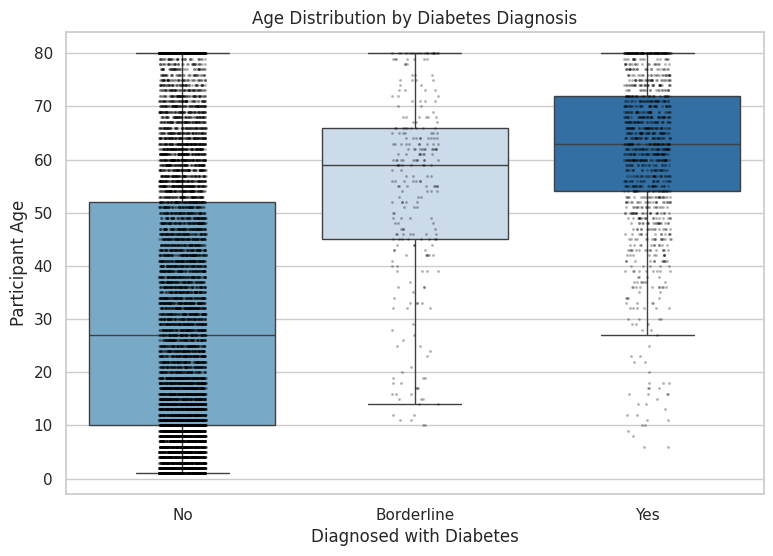

In [ ]:
plt.figure(figsize=(9,6))
cat_order = ['No', 'Borderline', 'Yes']

sns.boxplot(
    data=df,
    x='Dr_Diagnosed_Diab',
    y='Age',
    order=cat_order,
    hue='Dr_Diagnosed_Diab',
    palette='Blues',
    legend=False,
    showfliers=False
)
sns.stripplot(
    data=df, x='Dr_Diagnosed_Diab', y='Age',
    color='black', size=2, alpha=0.3
)
plt.title('Age Distribution by Diabetes Diagnosis')
plt.xlabel('Diagnosed with Diabetes')
plt.ylabel('Participant Age')
plt.show()

**Interpretation:**

***Kruskal–Wallis (Age and Diabetes):***

A Kruskal–Wallis test comparing Age across Diabetes status groups showed a significant difference in median age (H = 1832, p < 0.001).

***From the box-and-strip plot:***

Yes = oldest group (median ≈ mid-60s).

Borderline = intermediate (≈ late-50s/early-60s).

No = much younger overall (median ≈ late-20s) with many children/teens.

Therefore, older participants are much more likely to be in the Yes/Borderline groups, while younger participants are mostly No.

###2. Correlation: BMI vs Waist

In [ ]:
# Creating helper filters for adults and/or those with BMI / Waist Maeasurements
adults = df["Age"] >= 20
has_mec = df["BMI"].notna() & df["Waist_Circumference"].notna()
adult_mec = adults & has_mec            # adults who also have MEC exam measures

In [ ]:
# Hypothesis: BMI and waist circumference are positively correlated among adults with BMI/Waist (MEC) data:
d1 = df.loc[adult_mec, ["BMI", "Waist_Circumference"]].dropna()
r, p = stats.pearsonr(d1["BMI"], d1["Waist_Circumference"])
print(f"BMI and waist circumference are strongly related (Pearson r={r:.2f}, p={p:.3g}, n={len(d1)}).")

BMI and waist circumference are strongly related (Pearson r=0.91, p=0, n=8037).


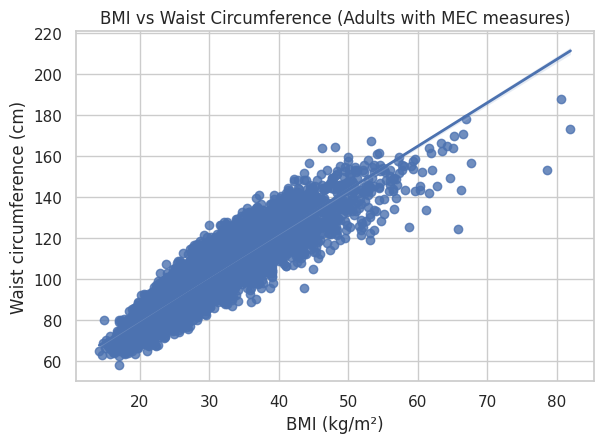

In [ ]:
# Visualizing the correlation through a scatterplot and a regression line:
plt.figure(figsize=(6.2, 4.6))
ax = sns.regplot(data=d1, x="BMI", y="Waist_Circumference", line_kws={"lw":2})
ax.set_title("BMI vs Waist Circumference (Adults with MEC measures)")
ax.set_xlabel("BMI (kg/m²)"); ax.set_ylabel("Waist circumference (cm)")
plt.tight_layout(); plt.show()

**BMI vs Waist Correlation Intepretaition:**

As expected, waist circumference increases almost linearly with BMI in the adults in our data, showing a very strong, statistically significant association (Pearson r=0.91, p=0.000, n=8037). This implies, that we may have to check the two features for multicollinearity, before including both in our model.

## 2. Chi- Squared Test: Race and Diabetes

In [ ]:
# 1. Create a Contingency Table:
diab_order = ['No', 'Borderline', 'Yes']  # column order for readability
ct = pd.crosstab(df['Race'], df['Dr_Diagnosed_Diab'])
ct = ct.reindex(columns=[c for c in diab_order if c in ct.columns])  # reorder
display(ct)

Dr_Diagnosed_Diab,No,Borderline,Yes
Race,,,
Mexican American,1558,28,175
NH Asian,1288,51,144
NH Black,3214,81,393
NH White,4060,73,428
Other Hispanic,1208,26,137
Other/Multiracial,820,9,71


In [ ]:
# 2. Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi-square statistic = {chi2:.3f}")
print(f"Degrees of freedom   = {dof}")
print(f"P-value              = {p:.6g}")

Chi-square statistic = 35.267
Degrees of freedom   = 10
P-value              = 0.000112409


In [ ]:
# 3. Measuring Effect size - Cramér's V (0=no association, ~0.1 small, ~0.3 medium, ~0.5 large)
n = ct.values.sum()
k = min(ct.shape)  # min(#rows, #cols)
cramers_v = np.sqrt(chi2 / (n * (k - 1))) if k > 1 else np.nan
print(f"Effect Size: Cramér's V = {cramers_v:.3f}")

Effect Size: Cramér's V = 0.036


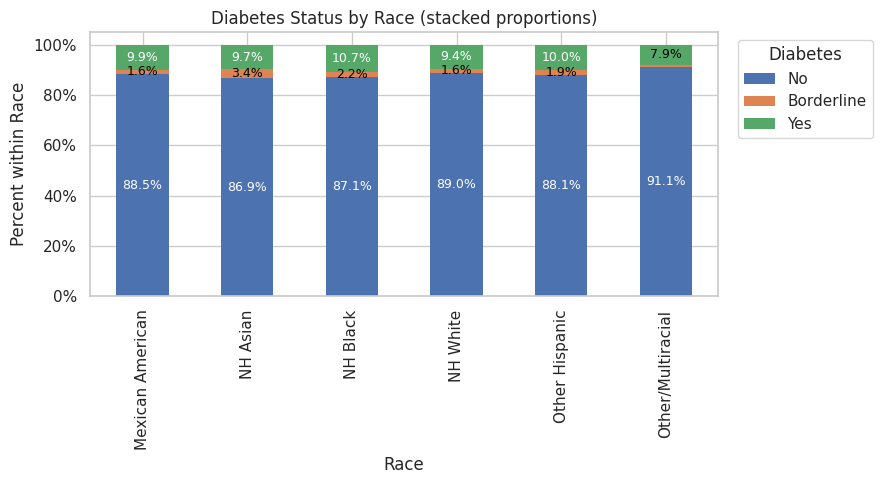

In [ ]:
# Plotting stacked % bar chart of Diabetes composition within each Race

props = ct.div(ct.sum(axis=1), axis=0)  # row-wise proportions

ax = props.plot(kind='bar', stacked=True, figsize=(9, 5), edgecolor='none')
ax.set_xlabel('Race')
ax.set_ylabel('Percent within Race')
ax.set_title('Diabetes Status by Race (stacked proportions)')
ax.legend(title='Diabetes', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 0–1 means 0–100%

# Add % labels on each stacked bar segment
for i, (race, row) in enumerate(props.iterrows()):
    cum_y = 0
    for status in props.columns:
        val = row[status]
        if val >= 0.015:  # skip tiny slices (<1%) to avoid clutter; tweak as needed
            y = cum_y + val / 2
            txt_color = 'white' if val > 0.08 else 'black'  # Contrast text color a bit: white on larger slices
            ax.text(i, y, f"{val*100:.1f}%", ha='center', va='center',
                    fontsize=9, color=txt_color, clip_on=True)
        cum_y += val

plt.tight_layout()
plt.show()

**Interpretation**

Chi-square Test for Race vs Diabetes status:  χ²(10) = 35.27, p = 1.12×10⁻⁴

Means that Race and Diabetes status are statistically not independent (p value < 0.05), but the effect is tiny (shown by Cramér’s V = 0.036).



***Observations from the Plot:***

- “Yes” ranges only 7.9–10.7% across race groups: highest in NH Black (10.7%), lowest in Other/Multiracial (7.9%).

- “Borderline” is slightly higher in NH Asian (3.4%) than others (~1.0–2.2%).

- “No” dominates everywhere (~87–91%), which is why the stacked bars look very similar.

Therefore, there is a statistically detectable Race–Diabetes association, but the practical difference is minimal. For prediction, we expect that Race will likely add just a little beyond stronger drivers like age, BMI, and waist circumference.